# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Wednesday, Feb 01, 2023 at 11:59pm**

## Table of Contents

- [Instructions](#si)
- [Introduction](#in)
- [Exercise 1: Introducing the dataset](#1)
- [Exercise 2: Exploratory data analysis (EDA)](#2)
- [Exercise 3: Preprocessing](#3)
- [Exercise 4: Building models](#4)
- [Exercise 5: Evaluating on the test set](#5)

## Imports 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
from pandas_profiling import ProfileReport

## Instructions <a name="si"></a>
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework (maximum group size: 2).** 

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [3]:
census_df = pd.read_csv("./adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={points:4}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (60%) and `test_df` (40%) with `random_state = 42`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here we're using a 60%/40% split because this is kind of a big dataset for a modest laptop. A smaller training set means that it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!_

In [4]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [5]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [6]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [7]:
train_df_nan.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features
rubric={points:10}

**Your tasks:**

1. Examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, use the `include="all"` argument to show summary statistics of all  features.
2. Visualize the histograms of numeric features. 
3. From the visualizations, which features seem relevant for the given prediction task?

> Note: (Optional) If you're feeling excited about this you are welcome to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA. 

In [8]:
train_df_nan.describe(include='all')

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,19536.000000,18428,1.953600e+04,19536,19536.000000,19536,18424,19536,19536,19536,19536.000000,19536.000000,19536.000000,19187,19536
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,13570,NaN,6256,NaN,9025,2490,7937,16676,13079,NaN,NaN,NaN,17517,14841
mean,38.592547,NaN,1.892662e+05,NaN,10.084767,NaN,NaN,NaN,NaN,NaN,1090.443540,86.537162,40.532606,NaN,NaN
std,13.638971,NaN,1.049020e+05,NaN,2.580723,NaN,NaN,NaN,NaN,NaN,7449.700833,402.395668,12.406636,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.177670e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.782835e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,2.368860e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


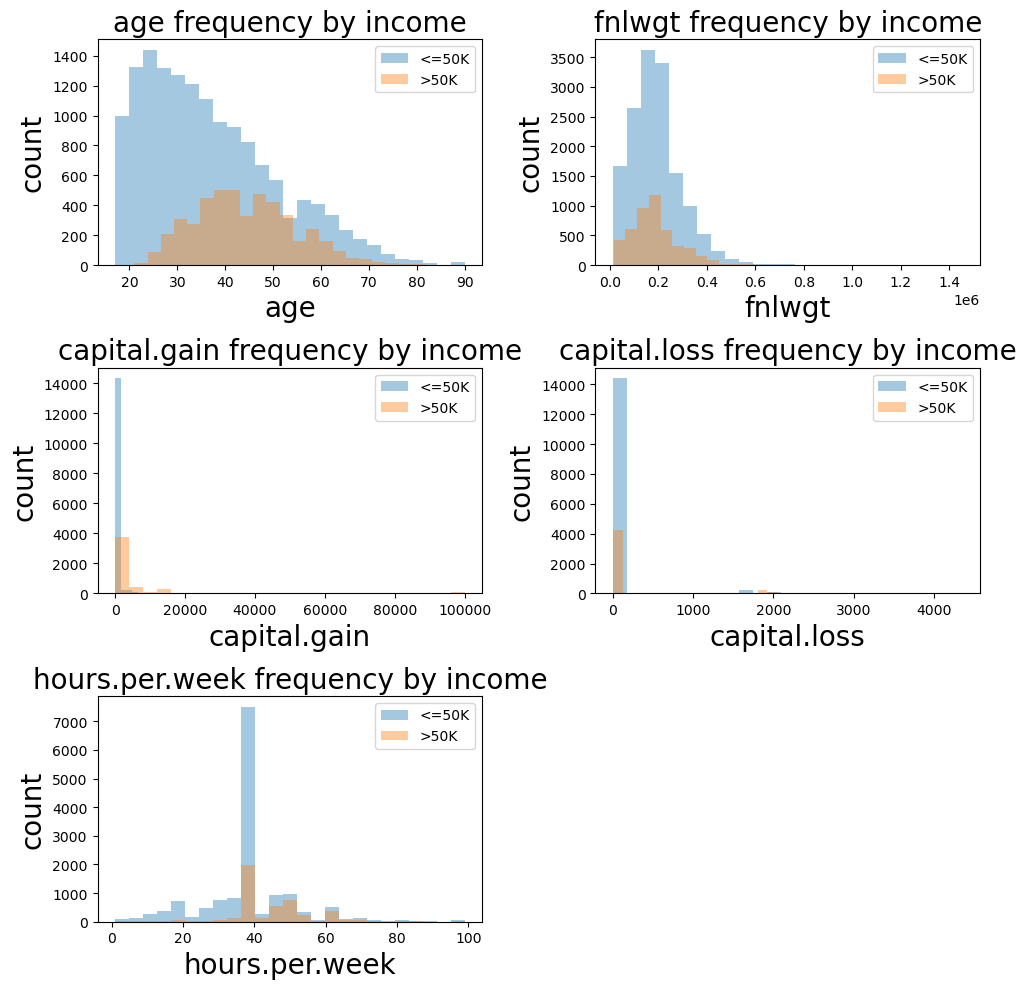

In [9]:
numeric_feats = [
    'age', 'fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week'
]

bins = 25
alpha=0.6

fig, ((ax0, ax1), (ax2, ax3), (ax4, _)) = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = [ax0, ax1, ax2, ax3, ax4]
below_50 = train_df_nan.loc[train_df_nan.income == '<=50K']
above_50 = train_df_nan.loc[train_df_nan.income == '>50K']
for i, f in enumerate(numeric_feats):
    axes[i].hist(below_50[numeric_feats[i]], bins, alpha=0.4, label="<=50K")
    axes[i].hist(above_50[numeric_feats[i]], bins, alpha=0.4, label=">50K")
    axes[i].set_title(f'{numeric_feats[i]} frequency by income', size=20)
    axes[i].set_xlabel(numeric_feats[i], size=20)
    axes[i].set_ylabel('count', size=20)
    axes[i].legend()

fig.delaxes(_)
fig.tight_layout()
plt.show()



In [10]:
# profile = ProfileReport(train_df_nan, title="Adult Census Income Report")
# profile.to_notebook_iframe()
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       18428 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      18424 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19187 non-null  object
 14  income          19536 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.4+ MB


From the numeric features visualized with histograms, relevant features to predict whether income exceeds 50k are:
* `age`
* `fnlwgt`: weights based on socio-economic characteristics
* `capital.gain`
* `capital.loss`
* `hours.per.week`

<br><br>

### 2.2 Identify transformations to apply
rubric={points:18}

**Your tasks:**
1. Identify the sequence of transformations that you would apply on each column in the dataset and fill in the table below accordingly. An example of the sequence of transformations to be applied on the `occupation` feature is shown in the table below. You may decide not to apply any transformations on a certain column or entirely drop a column from your model. That's totally fine. 
2. Are there common transformations you would like to apply on certain types of features? Identify different feature types for applying different transformations. In particular, fill in the lists below. 
3. Is including the `race` feature for predicting income ethically a good idea? Briefly discuss. 

> Note: This question is a bit open-ended and there is no single correct solution.

| Feature | Transformation |
| --- | ----------- |
| occupation | imputation, OHE |
| age | standardization |
| workclass | imputation, OHE |
| fnlwgt | standardization |
| education | OrdinalEncoder |
| education.num | use to determine ordinality of 'education' + drop |
| marital.status | OHE |
| relationship | OHE |
| race | OHE |
| sex | OHE drop="if_binary" |
| capital.gain | standardization |
| capital.loss | standardization |
| hours.per.week | standardization |
| native.country | imputation, OHE |


In [11]:
# Fill in the lists below. 
# It's OK to keep some of the lists empty or add new lists. 
numeric_features = ['age', 'fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['occupation', 'workclass', 'marital.status', 'relationship', 'race', 'native.country']
ordinal_features = ['education']
binary_features = ['sex']
drop_features = ['education.num']
passthrough_features = []
target = "income"

Including race for predicting income can be ethically a bad idea if proper measures to evaluate racial biases in the AI are not taken. Because the patterns that are identified by the model may be more advanced than what a human may be able to comprehend or analyze, it would be best to evaluate the AI prior to deployment. 

<br><br>

### 2.3 Separating feature vectors and targets  
rubric={points:4}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not?

In [12]:
X_train = train_df_nan.drop(columns=['income', 'education.num'])
y_train = train_df_nan['income']

X_test = test_df_nan.drop(columns=['income', 'education.num'])
y_test = test_df_nan['income']

<br><br><br><br>

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`
rubric={points:18}

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Note that you can define pipelines in two ways: 
- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly you can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

You may use the method of your choice but `make_pipeline` and `make_column_transformer` are highly recommended.  

**Your tasks:**

1. Create a column transformer `preprocessor` based on transformations you want to apply on the data from 2.2. 
2. Transform the data by calling `fit_transform` on the training set. What's the shape of the transformed data? 
3. Why do we need to use a column transformer in this case? Briefly explain. 

In [13]:
education_levels = train_df_nan[['education', 'education.num']].drop_duplicates().sort_values(by=['education.num'])['education'].to_numpy()

In [14]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),
        numeric_features,
    ),  # scaling on numeric features
    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features,
    ),  # Ordinal encoding on ordinal features
    (
        OneHotEncoder(drop="if_binary", dtype=int),
        binary_features,
    ),  # OHE on categorical features 
    (
        make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown="ignore")),
        categorical_features,
    ),  # OHE on categorical features
)

We need to use a column transformer because our different types of data require different preprocessing transformations and a column transformer allows us to do this in one step.

## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below is the function we used in class, which returns the mean cross-validation score along with standard deviation for a given model. Feel free to use it to keep track of your results if you like. 

In [15]:
results_dict = {} # dictionary to store all the results

In [16]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 
rubric={points:6}

**Your tasks:**
1. Define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict` above. Display the results as a pandas DataFrame.  

> You may use the function `mean_std_cross_val_scores` above to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [17]:
dummy = DummyClassifier(strategy="prior")
dummy_pipeline = make_pipeline(preprocessor, dummy)
results_dict['dummy'] = mean_std_cross_val_scores(
    dummy_pipeline, X_train, y_train, return_train_score=True, cv=5
)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.038 (+/- 0.004),0.012 (+/- 0.001),0.760 (+/- 0.000),0.760 (+/- 0.000)


<br><br>

### 4.2 Trying different classifiers
rubric={points:14}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store the results in `results_dict`. 
2. Display all the results so far as a pandas dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?  

> Note that this might take a while to run.

> You may use the function above `mean_std_cross_val_scores` to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [18]:
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

for k, v in models.items():
    pipeline = make_pipeline(preprocessor, v)
    results_dict[k] = mean_std_cross_val_scores(
        pipeline, X_train, y_train, return_train_score=True, cv=5
    )

In [19]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.038 (+/- 0.004),0.012 (+/- 0.001),0.760 (+/- 0.000),0.760 (+/- 0.000)
decision tree,0.192 (+/- 0.008),0.011 (+/- 0.001),0.817 (+/- 0.004),1.000 (+/- 0.000)
kNN,0.037 (+/- 0.003),1.603 (+/- 0.215),0.832 (+/- 0.005),0.882 (+/- 0.001)
RBF SVM,2.841 (+/- 0.044),0.516 (+/- 0.004),0.852 (+/- 0.005),0.854 (+/- 0.001)


##### Decision Tree

The validation accuracy is higher than the baseline validation accuracy, however, the gap between the validation accuracy and training accuracy is larger indicating overfitting.

This model has the middle-most `fit` time amongst the 3 models but has the fastest `score` time.

##### k Nearest Neighbors

The validation accuracy is higher than the baseline validation accuracy and the gap between validation accuracy and traing accuracy is small indicating that the model was not overfit or under fit.

This model has the shortest `fit` time, but the longest `score` time which is expected from kNN models with larger amounts of data since it takes a lot of time to calculate nearest neighbors when predicting new data.


##### RBF SVM

RBF SVM has the highest validation accuracy of the 3 models and a small gap between validation and training accuracy indicating the model has not been overfit or under fit.

This model has the highest `fit` time which is as expected since it determines a decision boundary when training using a kernel based similarity metric. It has the middle-most `score` time, not as fast as a decision tree model but much faster than the kNN model because the trained decision boundary makes predictions perform better and faster.

<br><br>

### (optional) 4.3 Exploring the importance of scaling
rubric={points:1}

In this exercise you'll examine whether scaling helps in case of KNNs and SVM RBFs. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results of scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not?

In [20]:
preprocessor_no_scale = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='median')),
        numeric_features,
    ),  # scaling on numeric features
    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features,
    ),  # Ordinal encoding on ordinal features
    (
        OneHotEncoder(drop="if_binary", dtype=int),
        binary_features,
    ),  # OHE on categorical features 
    (
        make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown="ignore")),
        categorical_features,
    ),  # OHE on categorical features
)

In [21]:
result_unscaled = {}
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

for k, v in models.items():
    pipeline = make_pipeline(preprocessor_no_scale, v)
    result_unscaled[f'{k} unscaled'] = mean_std_cross_val_scores(
        pipeline, X_train, y_train, return_train_score=True, cv=5
    )

In [22]:
pd.DataFrame(result_unscaled).T

,fit_time,score_time,test_score,train_score
decision tree unscaled,0.170 (+/- 0.005),0.010 (+/- 0.001),0.817 (+/- 0.003),1.000 (+/- 0.000)
kNN unscaled,0.036 (+/- 0.001),1.338 (+/- 0.038),0.774 (+/- 0.003),0.830 (+/- 0.002)
RBF SVM unscaled,3.563 (+/- 0.148),0.738 (+/- 0.002),0.789 (+/- 0.001),0.789 (+/- 0.000)


The performance of all models' validation scores decreased from using unscaled numeric features.

However, for decision trees, the difference was an insignificant amount. Scaling should not be necessary for decision tree classifiers because decision trees separate data at each split by a threshold in a numeric feature. These thresholds are the same whether the numeric data has been scaled or not, so the validation score should be unchanged.

### 4.4 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter: `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.1 and `SVC` classifier with the value of `C`.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best, and why? Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this might take a while. 

In [23]:
param_vals = np.logspace(-2, 2, num=5, base=10)
param_grid = {"C": np.delete(param_vals, np.where(param_vals == 1.0))}
param_grid

for c in param_grid['C']:
    pipeline = make_pipeline(preprocessor, SVC(C=c))
    results_dict[f'SVC C={c}'] = mean_std_cross_val_scores(
        pipeline, X_train, y_train, return_train_score=True, cv=5
    )
    

In [24]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.038 (+/- 0.004),0.012 (+/- 0.001),0.760 (+/- 0.000),0.760 (+/- 0.000)
decision tree,0.192 (+/- 0.008),0.011 (+/- 0.001),0.817 (+/- 0.004),1.000 (+/- 0.000)
kNN,0.037 (+/- 0.003),1.603 (+/- 0.215),0.832 (+/- 0.005),0.882 (+/- 0.001)
RBF SVM,2.841 (+/- 0.044),0.516 (+/- 0.004),0.852 (+/- 0.005),0.854 (+/- 0.001)
SVC C=0.01,12.075 (+/- 18.574),0.719 (+/- 0.009),0.783 (+/- 0.002),0.783 (+/- 0.003)
SVC C=0.1,3.189 (+/- 0.025),0.598 (+/- 0.003),0.840 (+/- 0.005),0.841 (+/- 0.002)
SVC C=10.0,3.042 (+/- 0.033),0.489 (+/- 0.004),0.854 (+/- 0.005),0.860 (+/- 0.002)
SVC C=100.0,4.639 (+/- 0.097),0.489 (+/- 0.006),0.855 (+/- 0.004),0.870 (+/- 0.002)


The hyperparameter of `C=100.0` is performing the best as opposed to the default hyperparameter by `scikit-learn` which is `C=1.0`. This is because increasing `C` increases the complexity of the model and the patterns that it identifies. However, this influences the fundamental tradeoff of increasing complexity and training accuracy but possibly lowering test accuracy by overfitting.

<br><br><br><br>

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={points:10}

**Your tasks:**

1. Train the best performing model on the entire training set. 
2. Report the results of this model on `X_test`. 
3. Are the cross-validation results and test results consistent? 

In [25]:
pipeline = make_pipeline(preprocessor, SVC(C=100.0))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[array(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9t...
                                                                 dtype=<class 'int'>),
                                                  ['education']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['sex']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['occupation', 'workclass',
                                                   'marital.status',
                                                   'relationship', 'race',
                                                   'native.country'])])),
                ('svc', SVC(C=100.0))])

In [26]:
print(f"Test score for best model: {pipeline.score(X_test, y_test)}")

Test score for best model: 0.8531285988483686


The cross-validation and test results do seem consistent because the validation `0.855 (+/- 0.004)` and test accuracies `0.853` are similar. However, usually we expect the test accuracy to be a bit lower than the validation accuracy. Random chance may be accountable for the validation and test accuracy being so similar rather than having a slightly larger gap.

## Exercise 6: Summary

rubric={Pass/Fail}

You are all done with Homework 3! Your last task is reflecting on what you have learned and answering the following questions. **This task is necessary to pass HW3**. Failing to complete this task means you will not receive points for this assignment.

1. In about 100 words, describe what you have learned from this homework.
2. Write at least one well-formulated question on something that is still not clear about the content of this homework, or you would like to know more about.

1. I have learned how to reason about how to preprocess different datatypes. By looking at a data set and categorizing myself, I have learned to apply the different transformation learned from class to new data. Additionally, I have learned to apply new technology in `sci-kit learn` such as `ColumnTransformer` and `pipeline`s to properly and efficiently preprocess, fit, cross-validate, and finally score against the test set. I also learned about the tradeoffs and differences between various models such as `kNN`, `Decision Tree`, and `SVC`. Finally, I visualized and reasoned about the importance of scaling and how it applies (or doesn't apply) to the models mentioned.

2. How do `SVC RBF` classifiers use a kernel-based similarity metric to fit a decision boundary and how does that contribute to training time as opposed to `kNN`'s faster training time.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done (**and don't forget to submit**)! 

![](./eva-well-done.png)

